### Import necessary headers

In [560]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

### Define folder paths

In [522]:
artifacts_path = os.getcwd().removesuffix('notebook\\model')+'artifacts\\'
model_endpoints = os.getcwd().removesuffix('notebook\\model')+'model_endpoints\\'

### Combined dataset

In [523]:
data = pd.read_csv(artifacts_path + 'eco-1990-2022.csv')

In [524]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Entity      99 non-null     object 
 1   Year        99 non-null     int64  
 2   we_avg_yr   99 non-null     float64
 3   fr          99 non-null     float64
 4   median_age  99 non-null     float64
 5   gdp_ppp     99 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 4.8+ KB


In [525]:
# data['emp_pop_ratio'] = data['emp_pop_ratio'].fillna(data['emp_pop_ratio'].mean())
# data['gdp_ppp'] = data['gdp_ppp'].fillna(data['gdp_ppp'].mean())
# data['fr_ratio'] = data['fr_ratio'].fillna(data['fr_ratio'].mean())

### Grouping datasets by country name

In [526]:
data_germany = data[data['Entity']=='Germany']
data_germany.drop(columns=['Entity'],inplace=True)
data_us = data[data['Entity'] == 'United States']
data_us.drop(columns=['Entity'], inplace=True)
data_india = data[data['Entity'] == 'India']
data_india.drop(columns=['Entity'], inplace=True)

C:\Users\sathy\AppData\Local\Temp\ipykernel_9720\1896909570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_germany.drop(columns=['Entity'],inplace=True)
C:\Users\sathy\AppData\Local\Temp\ipykernel_9720\1896909570.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_us.drop(columns=['Entity'], inplace=True)
C:\Users\sathy\AppData\Local\Temp\ipykernel_9720\1896909570.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_

In [527]:
data_germany.head(2)

,Year,we_avg_yr,fr,median_age,gdp_ppp
0,1990,8.74,1.460,36.600,2915.150994
1,1991,8.88,1.344,36.658,3064.064531


In [528]:
data_india.head(2)

,Year,we_avg_yr,fr,median_age,gdp_ppp
33,1990,2.4,4.045,19.687,1583.371287
34,1991,2.5,3.959,19.795,1600.104852


In [529]:
data_us.head(2)

,Year,we_avg_yr,fr,median_age,gdp_ppp
66,1990,12.62,2.072,31.903,10097.624386
67,1991,12.67,2.059,32.142,10086.692214


### Filtering countries

In [530]:
countries = ['United States', 'India', 'Germany']

### Consolidating the data under a single data structure

In [532]:
master_data = {'Germany':data_germany,'India':data_india,'United States':data_us}

### Model Training

Training the model, saving it under model_endpoints folder for future use, model training for each country for each featurem

In [ ]:
# targets = [ 'fr', 'median_age','we_avg_yr']
targets = [ 'median_age','we_avg_yr']

# Dictionary to store models and evaluation metrics
models = {}
results = {}
for country in countries:
    for target in targets:
        print(f"Training model for target : {target} for country {country}")
        
        X = master_data[country][['Year']]  # Features
        # Prepare target data
        Y = master_data[country][target]
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        
        # Initialize and train the Linear Regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        joblib.dump(model,model_endpoints + f'lr_{country}_{target}.pkl')
        print("Model saved successfully!")
        
        # Predictions
        y_pred = model.predict(X_test)
        
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Save model and results
        models[(country,target)] = model
        results[(country,target)] = {'MSE': mse, 'R2': r2}
        
        print(f"{(country,target)} -> MSE: {mse:.4f}, R2: {r2:.4f}")
        print('------------------------------------')
        
# Results summary
print("Model Performance:")
for target, metrics in results.items():
    print(f"{target}: MSE = {metrics['MSE']:.4f}, R2 = {metrics['R2']:.4f}")
print("==============================================")
    

Training model for target : median_age for country United States
Model saved successfully!
('United States', 'median_age') -> MSE: 0.0639, R2: 0.9540
------------------------------------
Training model for target : we_avg_yr for country United States
Model saved successfully!
('United States', 'we_avg_yr') -> MSE: 0.0080, R2: 0.5807
------------------------------------
Training model for target : median_age for country India
Model saved successfully!
('India', 'median_age') -> MSE: 0.1595, R2: 0.9676
------------------------------------
Training model for target : we_avg_yr for country India
Model saved successfully!
('India', 'we_avg_yr') -> MSE: 0.0144, R2: 0.9914
------------------------------------
Training model for target : median_age for country Germany
Model saved successfully!
('Germany', 'median_age') -> MSE: 0.3704, R2: 0.9406
------------------------------------
Training model for target : we_avg_yr for country Germany
Model saved successfully!
('Germany', 'we_avg_yr') -> M

In [534]:
# test_data_prep = [
#     {
#         'Year':year,
#         'Entity_encoded':entity, 
#         'fr':models['fr'].predict(pd.DataFrame([{'Year':year,'Entity_encoded':entity}]))[0], 
#     } 
#     for entity in data['Entity_encoded'].unique().tolist() for year in pred_year_range
#     ]
# test_data_prep_df = pd.DataFrame(test_data_prep)

In [535]:
# models[('India','fr')].intercept_

In [536]:
# # Assuming 'model' is the trained LinearRegression model
# intercept = models['fr'].intercept_  # Intercept (β0)
# coefficients = models['fr'].coef_ # Coefficients for each feature

# # Define feature names
# feature_names = ['Year', 'Entity_encoded', 'fr', 'median_age', 'we_avg_yr']

# # Print the equation
# print(f"Intercept (β0): {intercept:.4f}")
# for feature, coef in zip(feature_names, coefficients):
#     print(f"Coefficient for {feature} (β): {coef:.4f}")

# # Construct the linear equation
# equation = f"gdp_ppp = {intercept:.4f} + " + " + ".join(
#     [f"{coef:.4f} * {feature}" for feature, coef in zip(feature_names, coefficients)]
# )
# print("\nLinear Equation:")
# print(equation)


In [537]:
# test_data_prep = [
#     {
#         'Year':year,
#         'Entity_encoded':entity, 
#         'median_age':models['median_age'].predict(pd.DataFrame([{'Year':year,'Entity_encoded':entity}]))[0], 
#     } 
#     for entity in data['Entity_encoded'].unique().tolist() for year in pred_year_range
#     ]
# test_data_prep_df = pd.DataFrame(test_data_prep)

In [538]:
# # Assuming 'model' is the trained LinearRegression model
# intercept = models['median_age'].intercept_  # Intercept (β0)
# coefficients = models['median_age'].coef_ # Coefficients for each feature

# # Define feature names
# feature_names = ['Year', 'Entity_encoded', 'fr', 'median_age', 'we_avg_yr']

# # Print the equation
# print(f"Intercept (β0): {intercept:.4f}")
# for feature, coef in zip(feature_names, coefficients):
#     print(f"Coefficient for {feature} (β): {coef:.4f}")

# # Construct the linear equation
# equation = f"gdp_ppp = {intercept:.4f} + " + " + ".join(
#     [f"{coef:.4f} * {feature}" for feature, coef in zip(feature_names, coefficients)]
# )
# print("\nLinear Equation:")
# print(equation)


In [539]:
# # Create the line chart
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(12, 6))
# sns.lineplot(
#     data=test_data_prep_df,
#     x='Year',
#     y='median_age',
#     hue='Entity_encoded',  # Different lines for each country
#     palette='tab10'  # Optional color palette
# )

# # Customize the plot
# plt.title('median age Over Years by Country')
# plt.xlabel('Year')
# plt.ylabel('GDP (PPP)')
# plt.legend(title='Country')
# plt.grid(True)
# plt.tight_layout()

# # Show the plot
# plt.show()

In [540]:
# # Create the line chart
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(12, 6))
# sns.lineplot(
#     data=test_data_prep_df,
#     x='Year',
#     y='fr',
#     hue='Entity_encoded',  # Different lines for each country
#     palette='tab10'  # Optional color palette
# )

# # Customize the plot
# plt.title('FR Over Years by Country')
# plt.xlabel('Year')
# plt.ylabel('GDP (PPP)')
# plt.legend(title='Country')
# plt.grid(True)
# plt.tight_layout()

# # Show the plot
# plt.show()

In [541]:
pred_year_range = range(2023,2060)

In [542]:
# test_data_prep = [{'Year':j,'Entity':i} for i in data['Entity'] .unique().tolist() for j in pred_year_range]
# test_data_prep_df = pd.DataFrame(test_data_prep)

In [543]:
# models[('India','we_avg_yr')].predict(pd.DataFrame([{'Year':2023}]))[0]

### Training a linear model with Input Features as Year, Women Employment Average Years and Median Youth Age and the target variable is GDP

In [545]:
for country,dataset in master_data.items():
    # X = dataset[['Year','we_avg_yr','fr','median_age']]  # Features
    X = dataset[['Year','we_avg_yr','median_age']]  # Features
    Y = dataset[['gdp_ppp', ]]  # Targets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, Y_train)
    models[(country,'gdp_ppp')]=model
    Y_pred = model.predict(X_test)
    # Calculate MSE and R²
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)

    # Define the target name
    target_name = 'gdp_ppp'

    # Print MSE and R² for the target
    print("Performance Metrics:")
    print(f"{country} => {target_name}: Mean Squared Error = {round(mse, 2)}, R-squared = {round(r2, 2)}")
    print("------------------------------------------------------------------------")


Performance Metrics:
Germany => gdp_ppp: Mean Squared Error = 7032.39, R-squared = 0.95
------------------------------------------------------------------------
Performance Metrics:
India => gdp_ppp: Mean Squared Error = 16074.73, R-squared = 1.0
------------------------------------------------------------------------
Performance Metrics:
United States => gdp_ppp: Mean Squared Error = 106773.39, R-squared = 0.98
------------------------------------------------------------------------


### Trained models that are consolidated under a unified data structure for simpler access

In [546]:
models

{('United States', 'median_age'): LinearRegression(),
 ('United States', 'we_avg_yr'): LinearRegression(),
 ('India', 'median_age'): LinearRegression(),
 ('India', 'we_avg_yr'): LinearRegression(),
 ('Germany', 'median_age'): LinearRegression(),
 ('Germany', 'we_avg_yr'): LinearRegression(),
 ('Germany', 'gdp_ppp'): LinearRegression(),
 ('India', 'gdp_ppp'): LinearRegression(),
 ('United States', 'gdp_ppp'): LinearRegression()}

### Createing source data, which is apprantly an output of previoualy trained linear models

In [547]:
test_data_prep = [
    {
        'Year':year,
        'Entity':entity, 
        # 'fr':models[(entity,'fr')].predict(pd.DataFrame([{'Year':year}]))[0],
        'median_age':models[(entity,'median_age')].predict(pd.DataFrame([{'Year':year}]))[0],
        'we_avg_yr':models[(entity,'we_avg_yr')].predict(pd.DataFrame([{'Year':year}]))[0]   
    } 
    for entity in master_data.keys() for year in pred_year_range
    ]

In [548]:
# test_data_prep

### predicted outcomes

In [ ]:
raw_pred_data = [
    {
        'Year' : obj['Year'],
        'Entity' : obj['Entity'],
        'gdp_ppp' : models[(obj['Entity'],'gdp_ppp')].predict(pd.DataFrame([{'Year':obj['Year'],'we_avg_yr':obj['we_avg_yr'], 'median_age': obj['median_age']}]))[0][0]
    }
    for obj in test_data_prep
    ]
pred_data_df = pd.DataFrame(raw_pred_data)

## Analyzing Linear Growth
### GDP against Year for US,GER,IND


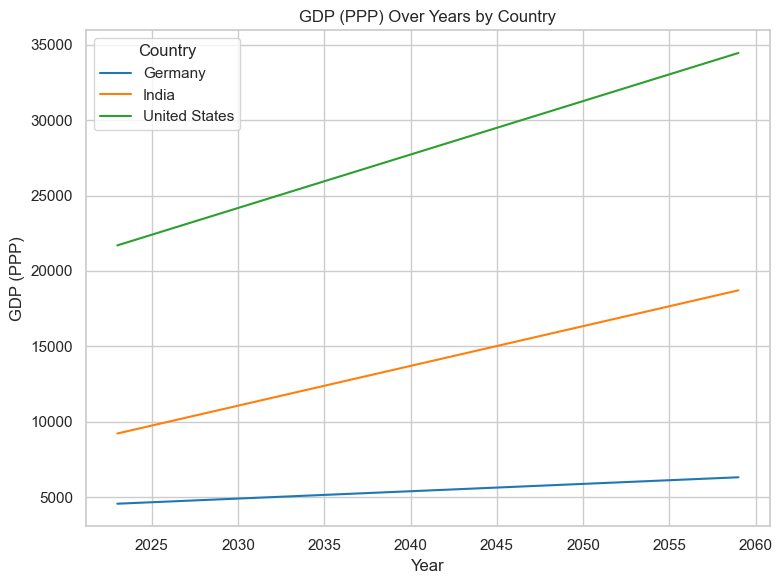

In [573]:
# Create the line chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.lineplot(
    data=pred_data_df,
    x='Year',
    y='gdp_ppp',
    hue='Entity',  # Different lines for each country
    palette='tab10'  # Optional color palette
)

# Customize the plot
plt.title('GDP (PPP) Over Years by Country')
plt.xlabel('Year')
plt.ylabel('GDP (PPP)')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

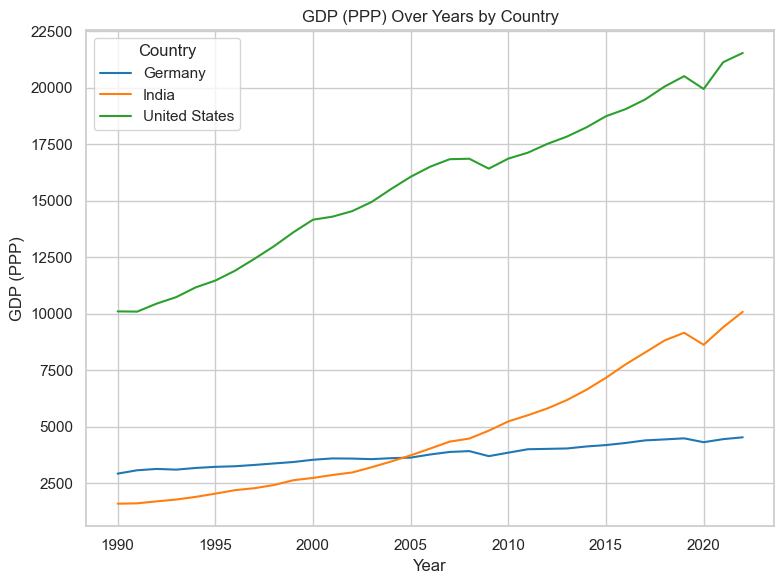

In [574]:
# Create the line chart
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=data,
    x='Year',
    y='gdp_ppp',
    hue='Entity',  # Different lines for each country
    palette='tab10'  # Optional color palette
)

# Customize the plot
plt.title('GDP (PPP) Over Years by Country')
plt.xlabel('Year')
plt.ylabel('GDP (PPP)')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [576]:
pred_data_df.to_csv(artifacts_path+'results.csv',index=False)